In [18]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns


In [20]:
Xtrain = pd.read_csv('./team13/task1/train_data.csv', header=None)
Ytrain = pd.read_csv('./team13/task1/train_label.csv', header=None)
Xtest = pd.read_csv('./team13/task1/test_data.csv', header=None)
Ytest = pd.read_csv('./team13/task1/test_label.csv', header=None)

In [23]:
class MLFFNN(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(MLFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


In [25]:
X_trainvals = Xtrain.values
Y_trainvals = Ytrain.values
X_testvals = Xtest.values
Y_testvals = Ytest.values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_trainvals)
X_test = scaler.transform(X_testvals)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(Y_trainvals)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(Y_testvals)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Pattern mode: batch_size=1

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Pattern mode: batch_size=1

In [27]:
def train(model, optimizer, criterion, train_loader, epochs, device):
    model.train()
    avg_errors = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            loss.backward()        
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_error = running_loss / len(train_loader)
        avg_errors.append(avg_error)
        
        if epoch > 0 and abs(avg_errors[-1] - avg_errors[-2]) < 1e-4:
            break
    
    return avg_errors, epoch + 1

In [29]:
# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    confusion_matrix = torch.zeros(5, 5)
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
    accuracy = correct / total
    return accuracy, confusion_matrix

In [31]:
import copy
# Set up the model and training parameters
input_size = 36
hidden1_size = 20
hidden2_size = 10
output_size = 5  # 5 classes (0 to 4)
learning_rate = 0.005 # 0.005 good
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLFFNN(input_size, hidden1_size, hidden2_size, output_size).to(device)

# After initializing the model
# initial_state_path = 'initial_model_state.pth'
# torch.save(model.state_dict(), initial_state_path)
initial_state = copy.deepcopy(model.state_dict())
criterion = nn.CrossEntropyLoss()

In [33]:
model.load_state_dict(copy.deepcopy(initial_state))
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
avg_errors, epochs_taken = train(model, optimizer, criterion, train_loader, epochs, device)

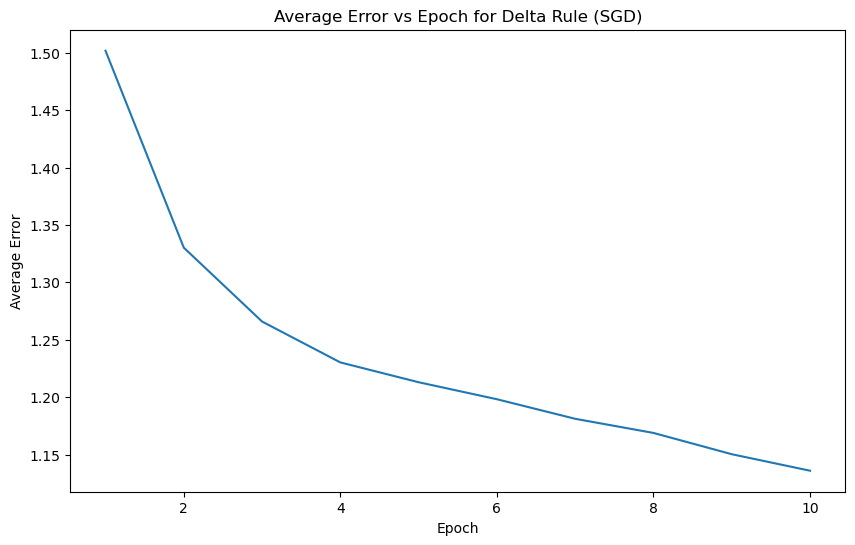

Epochs taken: 10
Train accuracy: 0.5920
Test accuracy: 0.5080

Training Confusion Matrix:

Test Confusion Matrix:


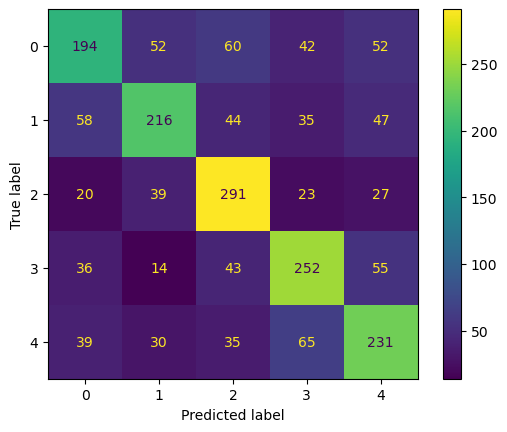

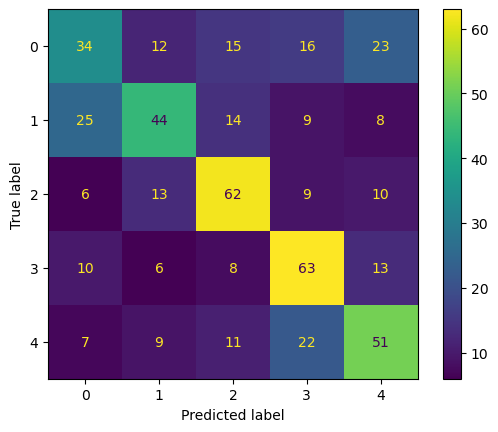

In [35]:
# Evaluate the model
train_accuracy, train_confusion = evaluate(model, train_loader, device)
test_accuracy, test_confusion = evaluate(model, test_loader, device)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_errors) + 1), avg_errors)
plt.xlabel("Epoch")
plt.ylabel("Average Error")
plt.title("Average Error vs Epoch for Delta Rule (SGD)")
plt.show()

print(f"Epochs taken: {epochs_taken}")
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names) #Using Seaborn to make it more visually appealing
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

class_names = [0, 1, 2, 3, 4]
print("\nTraining Confusion Matrix:")
# print(train_confusion.numpy())
ConfusionMatrixDisplay(train_confusion.numpy().astype(int)).plot()
print("\nTest Confusion Matrix:")
# print(test_confusion.numpy())
ConfusionMatrixDisplay(test_confusion.numpy().astype(int)).plot()

In [23]:
model.load_state_dict(copy.deepcopy(initial_state))
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
avg_errors, epochs_taken = train(model, optimizer, criterion, train_loader, epochs, device)

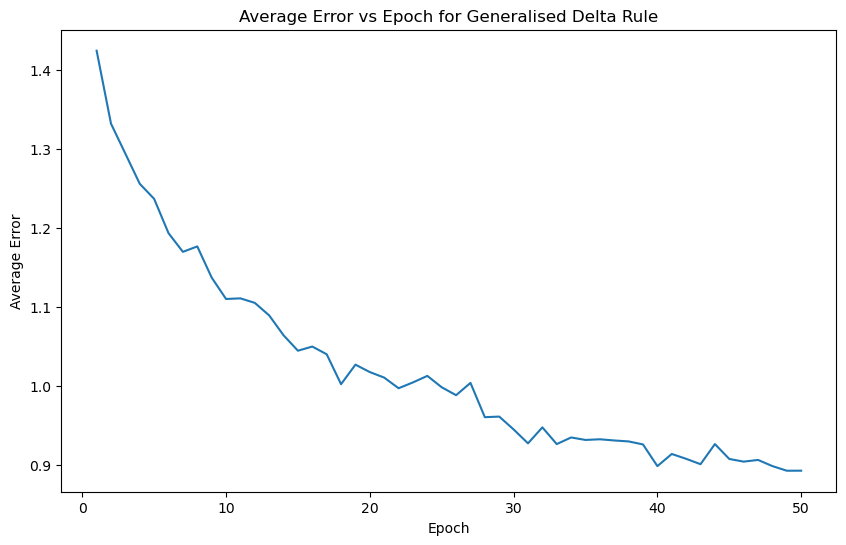

Epochs taken: 50
Train accuracy: 0.6870
Test accuracy: 0.4460

Training Confusion Matrix:

Test Confusion Matrix:


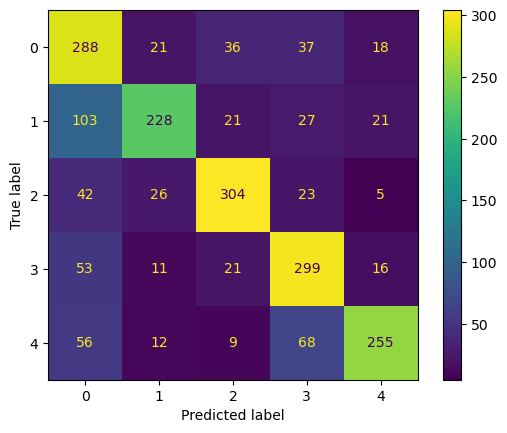

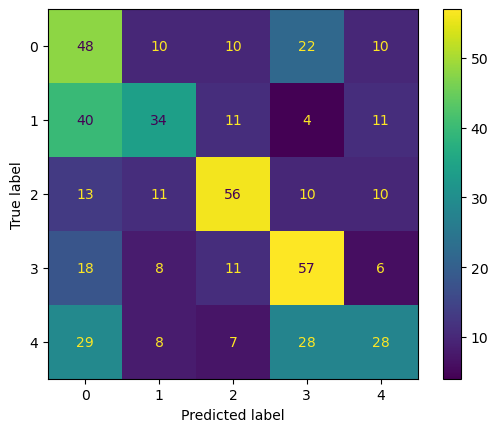

In [24]:
# Evaluate the model
train_accuracy, train_confusion = evaluate(model, train_loader, device)
test_accuracy, test_confusion = evaluate(model, test_loader, device)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_errors) + 1), avg_errors)
plt.xlabel("Epoch")
plt.ylabel("Average Error")
plt.title("Average Error vs Epoch for Generalised Delta Rule")
plt.show()

print(f"Epochs taken: {epochs_taken}")
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

def plot_confusion_matrix(cm, class_names):

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names) #Using Seaborn to make it more visually appealing
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

class_names = [0, 1, 2, 3, 4]
print("\nTraining Confusion Matrix:")
# print(train_confusion.numpy())
ConfusionMatrixDisplay(train_confusion.numpy().astype(int)).plot()
print("\nTest Confusion Matrix:")
# print(test_confusion.numpy())
ConfusionMatrixDisplay(test_confusion.numpy().astype(int)).plot()

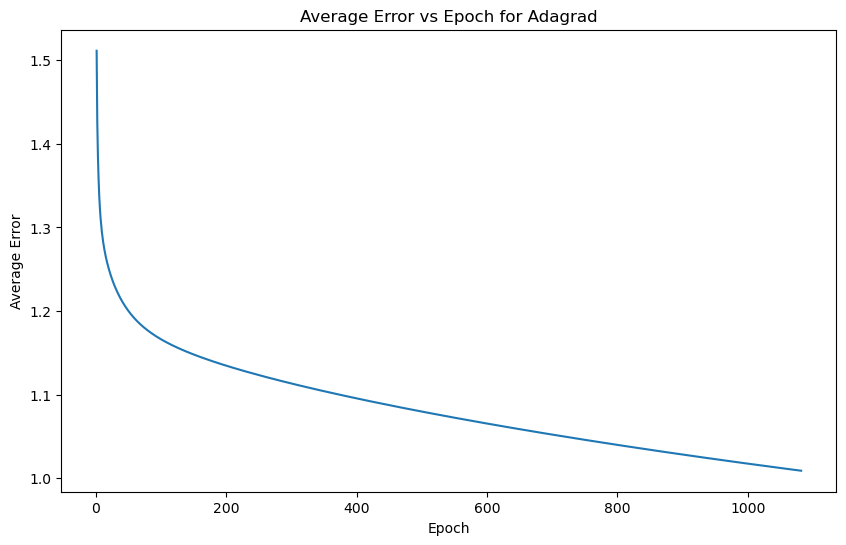

Epochs taken: 1082
Train accuracy: 0.6255
Test accuracy: 0.5020

Training Confusion Matrix:

Test Confusion Matrix:


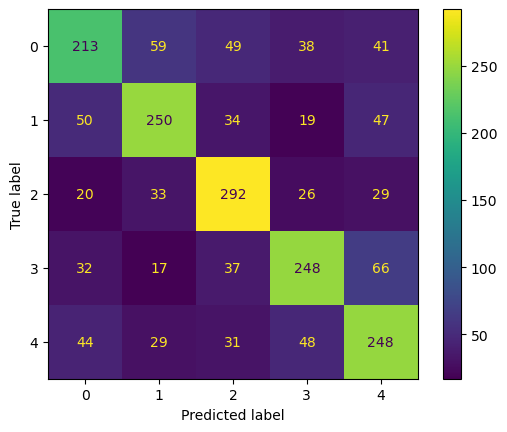

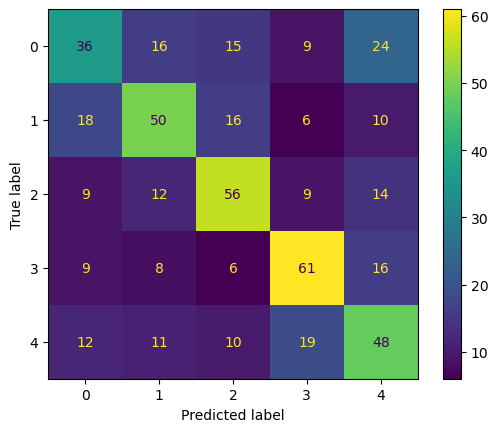

In [25]:
model.load_state_dict(copy.deepcopy(initial_state))
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
avg_errors, epochs_taken = train(model, optimizer, criterion, train_loader, epochs, device)

# Evaluate the model
train_accuracy, train_confusion = evaluate(model, train_loader, device)
test_accuracy, test_confusion = evaluate(model, test_loader, device)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_errors) + 1), avg_errors)
plt.xlabel("Epoch")
plt.ylabel("Average Error")
plt.title("Average Error vs Epoch for Adagrad")
plt.show()

print(f"Epochs taken: {epochs_taken}")
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

def plot_confusion_matrix(cm, class_names):

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names) #Using Seaborn to make it more visually appealing
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

class_names = [0, 1, 2, 3, 4]
print("\nTraining Confusion Matrix:")
# print(train_confusion.numpy())
ConfusionMatrixDisplay(train_confusion.numpy().astype(int)).plot()
print("\nTest Confusion Matrix:")
# print(test_confusion.numpy())
ConfusionMatrixDisplay(test_confusion.numpy().astype(int)).plot()

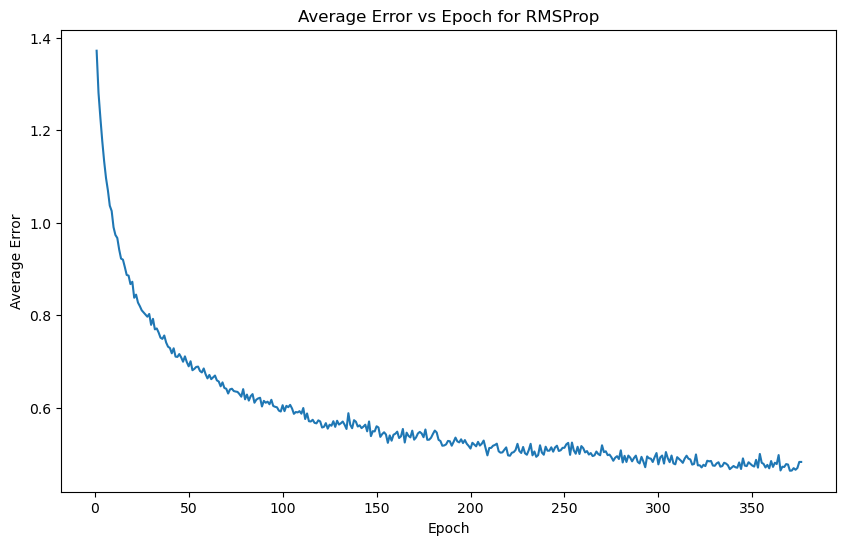

Epochs taken: 376
Train accuracy: 0.8485
Test accuracy: 0.4260

Training Confusion Matrix:

Test Confusion Matrix:


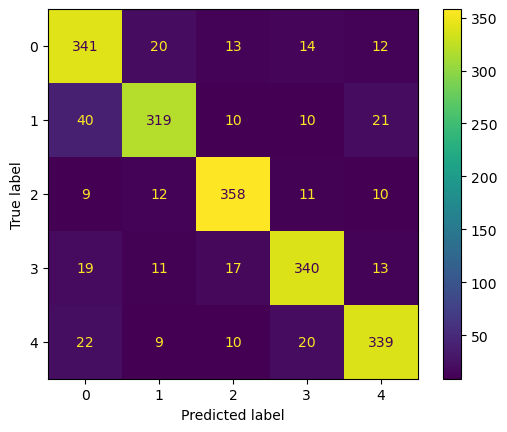

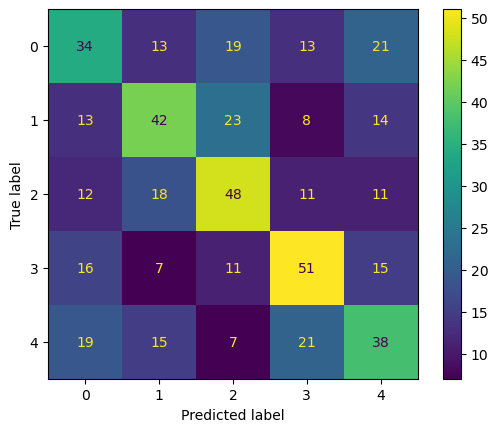

In [26]:
model.load_state_dict(copy.deepcopy(initial_state))
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
avg_errors, epochs_taken = train(model, optimizer, criterion, train_loader, epochs, device)

# Evaluate the model
train_accuracy, train_confusion = evaluate(model, train_loader, device)
test_accuracy, test_confusion = evaluate(model, test_loader, device)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_errors) + 1), avg_errors)
plt.xlabel("Epoch")
plt.ylabel("Average Error")
plt.title("Average Error vs Epoch for RMSProp")
plt.show()

print(f"Epochs taken: {epochs_taken}")
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

def plot_confusion_matrix(cm, class_names):

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names) #Using Seaborn to make it more visually appealing
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

class_names = [0, 1, 2, 3, 4]
print("\nTraining Confusion Matrix:")
# print(train_confusion.numpy())
ConfusionMatrixDisplay(train_confusion.numpy().astype(int)).plot()
print("\nTest Confusion Matrix:")
# print(test_confusion.numpy())
ConfusionMatrixDisplay(test_confusion.numpy().astype(int)).plot()

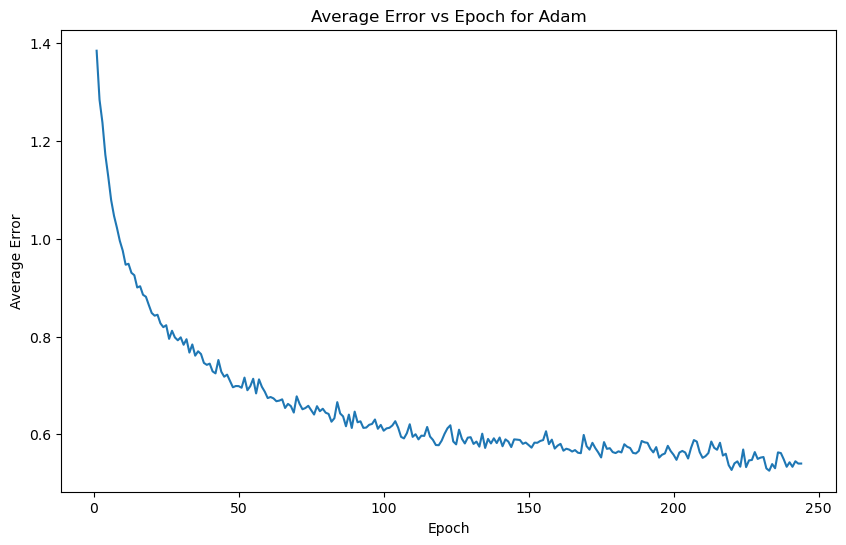

Epochs taken: 244
Train accuracy: 0.8060
Test accuracy: 0.4220

Training Confusion Matrix:

Test Confusion Matrix:


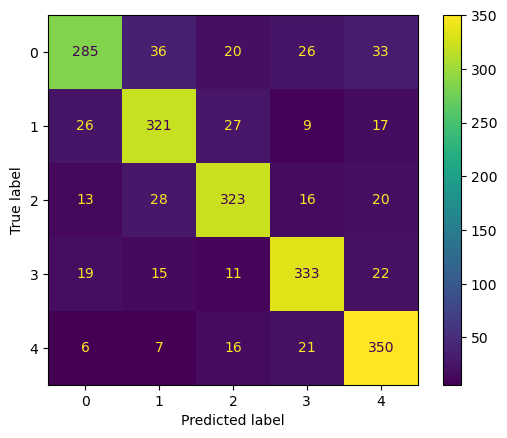

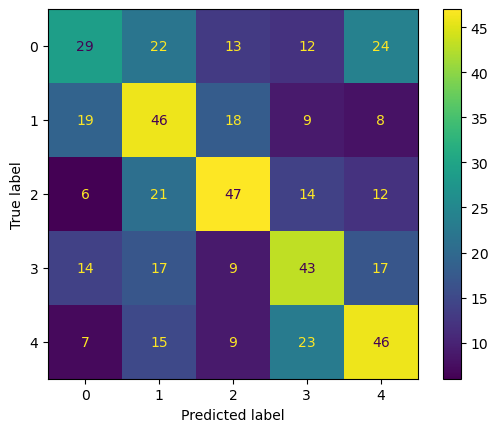

In [27]:
model.load_state_dict(copy.deepcopy(initial_state))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
avg_errors, epochs_taken = train(model, optimizer, criterion, train_loader, epochs, device)

# Evaluate the model
train_accuracy, train_confusion = evaluate(model, train_loader, device)
test_accuracy, test_confusion = evaluate(model, test_loader, device)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_errors) + 1), avg_errors)
plt.xlabel("Epoch")
plt.ylabel("Average Error")
plt.title("Average Error vs Epoch for Adam")
plt.show()

print(f"Epochs taken: {epochs_taken}")
print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

def plot_confusion_matrix(cm, class_names):

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names) #Using Seaborn to make it more visually appealing
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

class_names = [0, 1, 2, 3, 4]
print("\nTraining Confusion Matrix:")
# print(train_confusion.numpy())
ConfusionMatrixDisplay(train_confusion.numpy().astype(int)).plot()
print("\nTest Confusion Matrix:")
# print(test_confusion.numpy())
ConfusionMatrixDisplay(test_confusion.numpy().astype(int)).plot()

In [28]:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam